# Tarea 3: Regularización y Optimización <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas
## Nombre: Matias Cornejo

**Fecha de entrega: 29 de Octubre**


In [ ]:
# Este notebook está pensado para correr en CoLaboratory.
# Lo único imprescindible por importar es torch
import torch

# Posiblemenete quieras instalar e importar ipdb para debuggear.
# Si es así, descomenta lo siguiente:
# !pip install -q ipdb
# import ipdb

# Aqui instalamos la libreria de correccion del curso
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-xw23m7gz/cc6204_c0d94cfd4838439498dffe50a707aca4
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-xw23m7gz/cc6204_c0d94cfd4838439498dffe50a707aca4
  Created wheel for cc6204: filename=cc6204-0.5.0-py3-none-any.whl size=5800 sha256=45da1506a6e768362181753ea3c4e9e0b8d54da79caa6ea35855c92687c26ad0
  Stored in directory: /tmp/pip-ephem-wheel-cache-qkonvr5i/wheels/3c/26/f5/2abeb546c3ff1ab6e69113a3ae69bc0ac3442642727fd0dcc2
Successfully built cc6204


In [ ]:
# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# ingresa el host y port que posteamos en u-cursos
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# anota el token que te daremos en u-cursos
token = "]ye/Ox;nsz"

Connection stablished


Codigo util de Tarea 2

In [ ]:
import matplotlib.pyplot as plt
def plot_results(loss, acc):
  # Muestra dos figuras:
  #  (1) gráfico para la lista `loss` (Loss) y
  #  (2) gráfico para la lista `acc` (Accuracy)

  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss, c='r')
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title("Accuracy")
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('acc')
  ax2.plot(acc, c='b')
  f2.show()

In [ ]:
#Extraido de solución tarea 2
def sig(T, gradient=False):
  if gradient:
    sigT = sig(T)
    return sigT * (1 - sigT)
  return torch.reciprocal(1 + torch.exp(-1 * T))

def tanh(T, gradient=False):
  if gradient:
    tanhT = tanh(T)
    return 1 - tanhT * tanhT
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

def relu(T, gradient=False):
  if gradient:
    outT = torch.zeros_like(T)
    outT[T>=0] = 1
    return outT
  return torch.max(T, torch.zeros_like(T))

def swish(T, beta=1, gradient=False):
  if gradient:
    sigbT = sig(beta * T)
    swishT = T * sigbT
    return sigbT + beta * swishT * (1 - sigbT), swishT * (T - swishT)
  return T * torch.reciprocal(1 + torch.exp(-beta * T))

def celu(T, alpha=1, gradient=False):
  if alpha == 0:
    raise ValueError("alpha cannot be 0")

  zeros = torch.zeros_like(T)
  Talpha = T / alpha

  if gradient:
    e = Talpha.exp()
    d_dx = torch.ones_like(T)
    d_dx[T<0] = e[T<0]
    zeros[T<0] = (celu(T)[T<0] - T[T<0] * e[T<0]) / alpha
    return d_dx, zeros # d_dx, d_da

  return torch.max(zeros, T) + torch.min(zeros, alpha * (Talpha).expm1())

def softmax(T, dim, estable=True):
  if estable:
    T -= T.max(dim=dim, keepdim=True)[0]  # keepdim=True => output has dim with size 1. Otherwise, dim is squeezed
  exp = torch.exp(T)
  return exp / torch.sum(exp, dim=dim, keepdim=True)  # keepdim=True => output has dim with size 1. Otherwise, dim is squeezed

In [ ]:
def CELoss(Q, P, estable=True, epsilon=1e-8):
  # Q y P: representan distribuciones de probabilidad discreta
  #        (mediante matrices con las mismas dimensiones)
  # estable y epsilon: nos permiten lograr estabilidad numérica cuando
  #       intentamos computar el logaritmo de valores muy pequeños.
  #       epsilon limitará el valor mínimo del valor original cuando estable=True
  N = Q.shape[0]
  M = Q.shape[1]

  if estable:
    CEi = 0
    for i in range(N):
      CEi += (-1) * torch.sum(P[i] * torch.log(torch.max(torch.ones_like(Q[i])*epsilon, Q[i])))
  else:
    CEi = 0
    for i in range(N):
      CEi += (-1) * torch.sum(P[i] * torch.log(Q[i]))

  return CEi / N

In [ ]:
# Tu código acá
def CELoss(Q, P, estable=True, epsilon=1e-8):
  N = Q.shape[0]
  if estable:
    Q = Q.clamp(epsilon, 1-epsilon)
  return -(P * Q.log()).sum()/N

# Parte 1: Regularización y Generalización



## 1a) Regularización por *weight decay*

In [ ]:
# Tu código debiera continuar así
class SGD():
  def __init__(self, parameters, lr, beta=0):
    #p = (1-beta)*p - lr*p.grad
    # lo que sea necesario inicializar
    self.params = [p for p in parameters if p is not None]
    self.lr = lr
    self.beta = beta

  def step(self):
    # actualiza acá los parámetros a partir de los gradientes
    # y considera el nuevo valor beta

    for p in self.params:
      p.data = (1-self.beta)*p.data - self.lr * p.grad

In [ ]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="1a", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = SGD([weight], lr=0.1, beta=0.1)
optimizer.step()

# Submit
corrector.submit(homework=3, question="1a", test=1, token=token, answer=weight)

Correct Test!


## 1b) Regularización por dropout

Para esta parte de la tarea, va a ser necesario modificar el método `forward` para que entregue el valor a la salida de la i-esima capa escondida. Para esto se modifica el método forward para que reciba un parámetro `output_layer` que indica luego de que capa escondida se espera el output.

In [ ]:
# Tu código debiera continuar como sigue
from torch.nn import Parameter, ParameterList

class FFNN(torch.nn.Module): #red = FFNN(10, [1000], [sig], [None], 1, l_keep_prob=[1.0, 0.5]) /// red = FFNN(F, [50,30], [relu,sig], C)
  def __init__(self, F, l_h, l_a, l_a_params, C, l_keep_prob):
    super(FFNN, self).__init__()

    #From sol tarea 2
    sizes = [F] + l_h + [C] #En nuestro caso [784, 50, 30, 10]
    self.Ws = ParameterList([Parameter(torch.randn(sizes[i], sizes[i+1])) for i in range(len(sizes)-1)])
    self.bs = ParameterList([Parameter(torch.zeros(h)) for h in sizes[1:]])
    self.fs = l_a
    if l_a_params is not None:
      self.fs_ps_mask = [Parameter(torch.tensor(p)) if p else None for p in l_a_params]
    else:
      self.fs_ps_mask = [None for _ in l_a]
    self.fs_ps = ParameterList([p for p in self.fs_ps_mask if p])

    self.l_keep_prob = l_keep_prob

  def forward(self, x, predict=False):
    self.cacheU = [] #, self.cacheH = [], []
    self.cacheM = []
    i = 0
    for W, b, f, p in zip(self.Ws[:-1], self.bs[:-1], self.fs, self.fs_ps_mask):
      x = torch.mm(x, W) + b #u
      self.cacheU.append(x)
      x = f(x, p.item()) if p else f(x)  #h
      if(not predict):
        binomial = torch.distributions.binomial.Binomial(probs=self.l_keep_prob[i])
        i += 1
        b_mask  =  binomial.sample(x.size())
        self.cacheM.append(b_mask)
        x = (x * b_mask)

    return softmax(torch.mm(x, self.Ws[-1]) + self.bs[-1], dim=1)

  def backward(self, x, y, y_pred):
    current_grad = (y_pred - y) / y.size(0)

    for i in range(len(self.Ws)-1, 0, -1):
      if self.fs_ps_mask[i-1] is None:
        # funcion de activacion sin parametro
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1]).t() @ current_grad
      else:
        # funcion de activacion con parametro
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1].item()).t() @ current_grad
      self.bs[i].grad = current_grad.sum(dim=0)
      h_grad = current_grad @ self.Ws[i].t()

      if self.fs_ps_mask[i-1] is None:
        # funcion de activacion sin parametro
        current_grad = self.fs[i-1](self.cacheU[i-1], gradient=True) * h_grad
      else:
        # funcion de activacion con parametro
        current_grad, p_grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1], gradient=True)
        current_grad *= h_grad
        self.fs_ps_mask[i-1].grad = (p_grad * h_grad).sum()

    self.Ws[0].grad = x.t() @ current_grad
    self.bs[0].grad = current_grad.sum(dim=0)

In [ ]:
# Tests del API del curso
torch.manual_seed(0)
sample = torch.rand(1, 10)
red = FFNN(10, [1000], [sig], [None], 1, l_keep_prob=[1.0, 0.5])
y = red(sample)
output_mask = (y == 0)
percent = torch.sum(output_mask).item() / list(output_mask.size())[-1]

# Submit
corrector.submit(homework=3, question="1b", test=1, token=token, answer=percent)

Correct Test!


## 1c) Entrenamiento y generalización sobre MNIST

In [ ]:
#Codigo extraido de: https://github.com/amitrajitbose/handwritten-digit-recognition
from google.colab import drive

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Download and load the training data
mnist_dataset = MNIST('mnist', train=True, transform=ToTensor(), download=True)
print('Cantidad total de datos:',len(mnist_dataset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw

Cantidad total de datos: 60000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
from tqdm import tqdm
def entrenar_FFNN(red, dataset, optimizador, epochs=1, batch_size=1, device='cuda'):
  red.to(device)

  # Inicialicemos un DataLoader para los ejemplos de dataset
  data = DataLoader(dataset, batch_size, shuffle=True)
  total=len(dataset)

  # Comienza el entrenamiento
  loss, acc = [], []
  for e in tqdm(range(1,epochs+1)):
    for x, y in data: #size(x) = (B,1,28,28)
      #x = x.view(x.shape[0],-1)      #size(x) = (B,28*28)
      #x, y = x.to(device), y.to(device)
      x, y = x.view(x.size(0), -1).float().to(device), y.to(device)

      y_pred = red(x)
      y_onehot = torch.zeros_like(y_pred)
      y_onehot[torch.arange(x.size(0)), y] = 1.

      red.backward(x, y_onehot, y_pred)

      optimizador.step()

    #Calculo de acc en cada epoca
    X = dataset.data.view(len(dataset), -1).float().to(device)
    Y = dataset.targets.to(device)
    Y_PRED = red.forward(X,predict=True).to(device)

    Y_onehot = torch.zeros_like(Y_PRED)
    Y_onehot[torch.arange(X.size(0)), Y] = 1.

    L_total = CELoss(Y_PRED, Y_onehot)
    loss.append(L_total)
    diff = Y-torch.argmax(Y_PRED,1)
    errores = torch.nonzero(diff).size(0)

    Acc=100*(total-errores)/total
    acc.append(Acc)


  return loss, acc

100%|██████████| 20/20 [07:28<00:00, 22.41s/it]


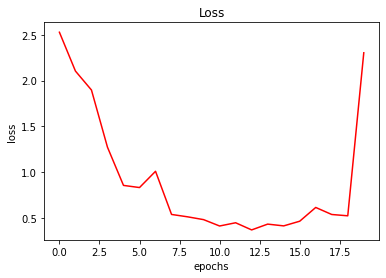

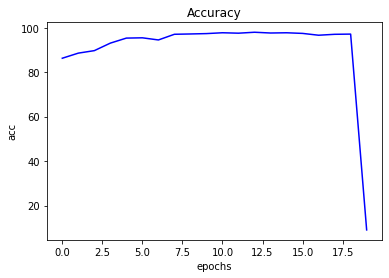

In [ ]:
red = FFNN(784, [512, 1024, 128], [relu, relu, relu], [None,None,None], 10, l_keep_prob=[1.0, 0.7, 0.5]) #red = FFNN(F, [50,30], [relu,sig], C)
optimizer = SGD(red.parameters(), lr=1e-5, beta=0) #optimizador = SGD(red.parameters(), 0.001)

with torch.no_grad():
  loss, acc = entrenar_FFNN(red, mnist_dataset, optimizer, epochs=20, batch_size=32, device='cuda')

plot_results(loss,acc)

100%|██████████| 30/30 [08:29<00:00, 16.99s/it]


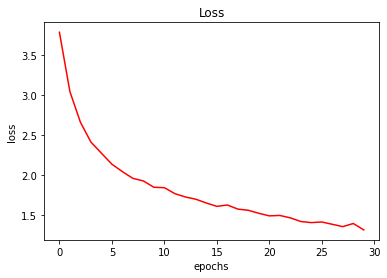

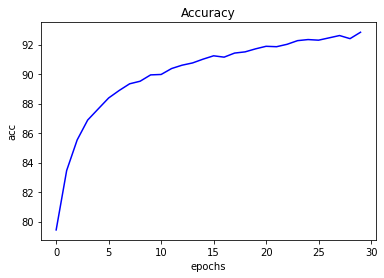

In [ ]:
red = FFNN(784, [512, 1024, 128], [relu, relu, relu], [None,None,None], 10, l_keep_prob=[1.0, 1.0, 1.0]) #red = FFNN(F, [50,30], [relu,sig], C)
optimizer = SGD(red.parameters(), lr=1e-5, beta=0) #optimizador = SGD(red.parameters(), 0.001)

with torch.no_grad():
  loss, acc = entrenar_FFNN(red, mnist_dataset, optimizer, epochs=30, batch_size=32, device='cuda')

plot_results(loss,acc)

# Parte 2: Optimización

## 2a) Inicialización de Xavier/He

Para los test de esta parte vamos a necesitar que modifiques tu código para que se pueda entregar valores predeterminados de `r`. Ahora tu código para las inicializaciones debe ser: `xavier_init(first_dim, second_dim, r=None)`, `he_init(first_dim, second_dim, r=None)`.

In [ ]:
# Tu código debiera continuar como sigue
from numpy import sqrt
def xavier_init(first_dim, second_dim, r=None):
  if(r==None):
    W_xr = torch.randn(first_dim, second_dim) * sqrt( 1 / first_dim )
  else:
    W_xr = r * sqrt( 1 / first_dim )

  return W_xr

def he_init(first_dim, second_dim, r=None):
  if(r==None):
    W_he = torch.randn(first_dim, second_dim) * sqrt( 2 / first_dim )
  else:
    W_he = r * sqrt( 2 / first_dim )
  return W_he

In [ ]:
# Tests del API del curso
r_xavier = corrector.get_test_data(homework=3, question="2a", test=1, token=token)
r_he = corrector.get_test_data(homework=3, question="2a", test=2, token=token)

w_xavier = xavier_init(50, 50, torch.tensor(r_xavier))
w_he = he_init(50, 50, torch.tensor(r_he))

corrector.submit(homework=3, question="2a", test=1, token=token, answer=w_xavier)
corrector.submit(homework=3, question="2a", test=2, token=token, answer=w_he)

Correct Test!
Correct Test!


## 2b) Descenso de gradiente con momentum

In [ ]:
class SGD():
  def __init__(self, parameters, lr, beta=0, momentum=0):
    self.params = [p for p in parameters if p is not None]
    self.lr = lr
    self.momentum = momentum
    self.beta = beta
    self.v = [None for p in self.params]

  def step(self):
    # actualiza acá los parámetros a partir de los gradientes
    # y considerando el valor de momentum que acabámos de agregar
    for i, p in enumerate(self.params):
      if(self.v[i] == None):
        self.v[i] = torch.zeros_like(p.data)

      self.v[i] = self.momentum * self.v[i] - self.lr * p.grad
      p.data = (1-self.beta)*p.data + self.v[i] #p.data = (1-self.beta)*p.data - self.lr * p.grad

In [ ]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="2b", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = SGD([weight], lr=0.1, momentum=0.9)
optimizer.step()

# Submit
corrector.submit(homework=3, question="2b", test=1, token=token, answer=weight)
optimizer.step()
corrector.submit(homework=3, question="2b", test=2, token=token, answer=weight)

Correct Test!
Correct Test!


## 2c) RMSProp

In [ ]:
# Tu código acá

class RMSProp():
  def __init__(self, parameters, lr=0.001, beta=0.9, epsilon=1e-8):
    self.params = [p for p in parameters if p is not None]
    self.lr = lr
    self.beta = beta
    self.epsilon = epsilon
    self.s = [None for p in self.params]

  def step(self):
    for i, p in enumerate(self.params):
      if(self.s[i] == None):
        self.s[i] = torch.zeros_like(p.data)

      self.s[i] = self.beta * self.s[i] + (1 - self.beta) * (p.grad * p.grad)       #self.momentum * self.v - self.lr * p.grad
      p.data = p.data -  (self.lr / (sqrt(self.s[i]) + self.epsilon) ) * p.grad                                            #p.data = (1-self.beta)*p.data - self.lr * p.grad

In [ ]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="2c", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = RMSProp([weight], lr=0.001, beta=0.9, epsilon=1e-8)
optimizer.step()

# Submit
corrector.submit(homework=3, question="2c", test=1, token=token, answer=weight)
optimizer.step()
corrector.submit(homework=3, question="2c", test=2, token=token, answer=weight)

Using cached test data
Correct Test!
Correct Test!


## 2d) Adam

In [ ]:
# Tu código acá

class Adam():
  def __init__(self, parameters, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    self.params = [p for p in parameters if p is not None]
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.p = [None for p in self.params]
    self.s = [None for p in self.params]
    self.n = 1

  def step(self):
    for i, par in enumerate(self.params):
      if(self.p[i] == None):
        self.p[i] = torch.zeros_like(par.data)
      if(self.s[i] == None):
        self.s[i] = torch.zeros_like(par.data) # self.s = self.beta * self.s + (1 - self.beta) * (p.grad * p.grad)

      self.p[i] = self.beta1 * self.p[i] + (1 - self.beta1) * par.grad
      self.s[i] = self.beta2 * self.s[i] + (1 - self.beta2) * (par.grad * par.grad)

      p_m = self.p[i] / (1 - self.beta1 ** self.n)
      s_m = self.s[i] / (1 - self.beta2 ** self.n)

      self.n += 1

      par.data = par.data -  (self.lr / (sqrt(s_m) + self.epsilon) ) * p_m

In [ ]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="2d", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = Adam([weight], lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8)
optimizer.step()

# Submit
corrector.submit(homework=3, question="2d", test=1, token=token, answer=weight)
optimizer.step()
corrector.submit_check_some(homework=3, question="2d", tests=[2, 3], token=token,
                            answer_dict={2: weight, 3: weight}, required_number=1)

Correct Test!
Correct Test!


## 2e) Entrenamiento en MNIST

Usa tu red neuronal para entrenar con los datos de MNIST y compara cómo cambian las curvas de entrenamiento dependiendo de factores como la inicialización y los algoritmos que utilices. Presenta al menos dos gráficos en donde compares. Por ejemplo, puedes presentar uno que para la misma estrategia de inicialización, los tres algoritmos de optimización para varias épocas y cómo evoluciona la pérdida y el acierto. En cada caso comenta que conclusiones puedes sacar. Algunos ejemplos de preguntas que podrías tratar de responder son:
* ¿cómo afecta el algoritmo de optimización al tiempo de convergencia de la red para los datos de entrenamiento?
* ¿cómo afecta el algoritmo de optimización en el acierto alcanzado por la red en los datos de prueba?
* Si haces la parte opcional de Batch Normalization, puedes también preguntarte cosas como si aplicar, o no, BN afecta a todos los algoritmos de optimización por igual.

In [ ]:
# Tu código debiera continuar como sigue
from torch.nn import Parameter, ParameterList

class FFNN(torch.nn.Module): #red = FFNN(10, [1000], [sig], [None], 1, l_keep_prob=[1.0, 0.5]) /// red = FFNN(F, [50,30], [relu,sig], C)
  def __init__(self, F, l_h, l_a, l_a_params, C, l_keep_prob):
    super(FFNN, self).__init__()

    #From sol tarea 2
    sizes = [F] + l_h + [C] #En nuestro caso [784, 50, 30, 10]
    self.Ws = ParameterList([Parameter(xavier_init(sizes[i], sizes[i+1])) for i in range(len(sizes)-1)])
    self.bs = ParameterList([Parameter(torch.zeros(h)) for h in sizes[1:]])
    self.fs = l_a
    if l_a_params is not None:
      self.fs_ps_mask = [Parameter(torch.tensor(p)) if p else None for p in l_a_params]
    else:
      self.fs_ps_mask = [None for _ in l_a]
    self.fs_ps = ParameterList([p for p in self.fs_ps_mask if p])

    self.l_keep_prob = l_keep_prob

  def forward(self, x, predict=False):
    self.cacheU = [] #, self.cacheH = [], []
    self.cacheM = []
    i = 0
    for W, b, f, p in zip(self.Ws[:-1], self.bs[:-1], self.fs, self.fs_ps_mask):
      x = torch.mm(x, W) + b #u
      self.cacheU.append(x)
      x = f(x, p.item()) if p else f(x)  #h
      if(not predict):
        binomial = torch.distributions.binomial.Binomial(probs=self.l_keep_prob[i])
        i += 1
        b_mask  =  binomial.sample(x.size())#.to('cuda')
        self.cacheM.append(b_mask)
        x = (x * b_mask)

    return softmax(torch.mm(x, self.Ws[-1]) + self.bs[-1], dim=1)

  def backward(self, x, y, y_pred):
    current_grad = (y_pred - y) / y.size(0)

    for i in range(len(self.Ws)-1, 0, -1):
      if self.fs_ps_mask[i-1] is None:
        # funcion de activacion sin parametro
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1]).t() @ current_grad
      else:
        # funcion de activacion con parametro
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1].item()).t() @ current_grad
      self.bs[i].grad = current_grad.sum(dim=0)
      h_grad = current_grad @ self.Ws[i].t()

      if self.fs_ps_mask[i-1] is None:
        # funcion de activacion sin parametro
        current_grad = self.fs[i-1](self.cacheU[i-1], gradient=True) * h_grad
      else:
        # funcion de activacion con parametro
        current_grad, p_grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1], gradient=True)
        current_grad *= h_grad
        self.fs_ps_mask[i-1].grad = (p_grad * h_grad).sum()

    self.Ws[0].grad = x.t() @ current_grad
    self.bs[0].grad = current_grad.sum(dim=0)

100%|██████████| 25/25 [23:50<00:00, 57.23s/it]


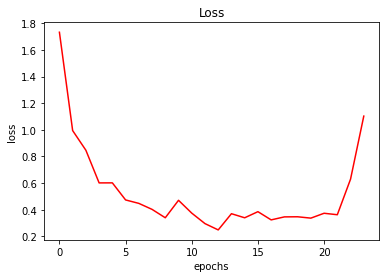

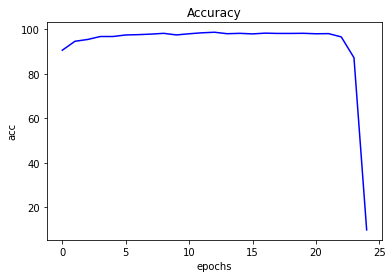

In [ ]:
red = FFNN(784, [512, 1024, 128], [relu, relu, relu], [None,None,None], 10, l_keep_prob=[1.0, 0.7, 0.5]) #red = FFNN(F, [50,30], [relu,sig], C)
optimizer = SGD(red.parameters(), lr=1e-2, beta=0) #optimizador = SGD(red.parameters(), 0.001)
#optimizer = SGD([weight], lr=1e-5, momentum=0.9)

with torch.no_grad():
  loss, acc = entrenar_FFNN(red, mnist_dataset, optimizer, epochs=25, batch_size=32, device='cpu')

plot_results(loss,acc)

Comparando este gráfico con los de SGD anteriores, se aprecia que se necesitan menos epocas para lograr una buena presición, es decir converge antes.


100%|██████████| 25/25 [24:18<00:00, 58.33s/it]


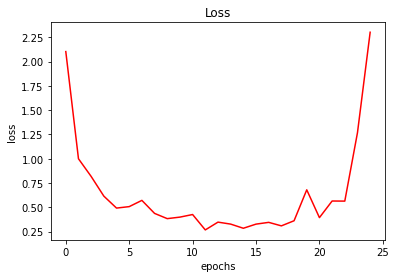

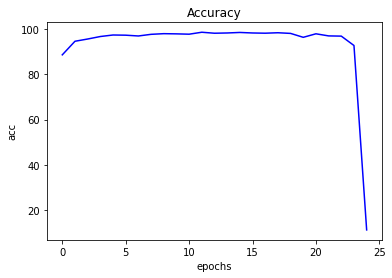

In [ ]:
red = FFNN(784, [512, 1024, 128], [relu, relu, relu], [None,None,None], 10, l_keep_prob=[1.0, 0.7, 0.5]) #red = FFNN(F, [50,30], [relu,sig], C)
#optimizer = SGD(red.parameters(), lr=1e-2, beta=0) #optimizador = SGD(red.parameters(), 0.001)
optimizer = SGD(red.parameters(), lr=1e-3, momentum=0.9)

with torch.no_grad():
  loss, acc = entrenar_FFNN(red, mnist_dataset, optimizer, epochs=25, batch_size=32, device='cpu')

plot_results(loss,acc)

Al utilizar momentun no se observa un cambio tan grande, pero cabe destacar que el gráfico de Loss tiene una variación más leve con respecto al optimizador sin momentum.

100%|██████████| 25/25 [17:21<00:00, 41.66s/it]


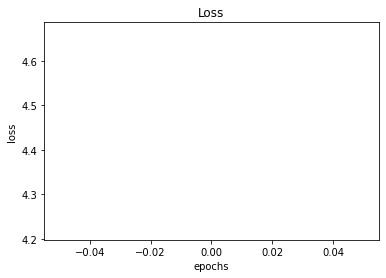

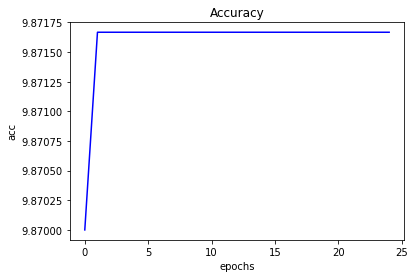

In [ ]:
red = FFNN(784, [512, 1024, 128], [relu, relu, relu], [None,None,None], 10, l_keep_prob=[1.0, 0.7, 0.5]) #red = FFNN(F, [50,30], [relu,sig], C)
#optimizer = SGD(red.parameters(), lr=1e-2, beta=0) #optimizador = SGD(red.parameters(), 0.001)
optimizer = SGD(red.parameters(), lr=1e-1, momentum=0.9)

with torch.no_grad():
  loss, acc = entrenar_FFNN(red, mnist_dataset, optimizer, epochs=25, batch_size=32, device='cpu')

plot_results(loss,acc)

Aca se utiliza un lr más grande y tampoco hay una variación tan grande

100%|██████████| 25/25 [40:09<00:00, 96.39s/it]


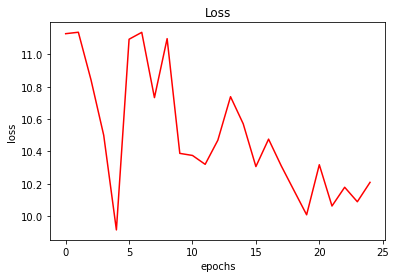

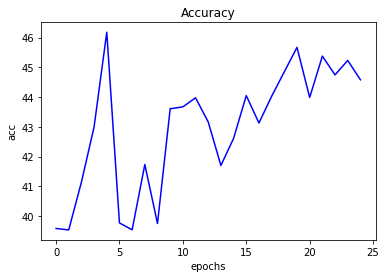

In [ ]:
red = FFNN(784, [512, 1024, 128], [relu, relu, relu], [None,None,None], 10, l_keep_prob=[1.0, 0.7, 0.5]) #red = FFNN(F, [50,30], [relu,sig], C)
#optimizer = SGD(red.parameters(), lr=1e-2, beta=0) #optimizador = SGD(red.parameters(), 0.001)
#optimizer = SGD(red.parameters(), lr=1e-1, momentum=0.9)
optimizer = RMSProp(red.parameters(), lr=1e-1, beta=0.9, epsilon=1e-8)

with torch.no_grad():
  loss, acc = entrenar_FFNN(red, mnist_dataset, optimizer, epochs=25, batch_size=32, device='cpu')

plot_results(loss,acc)

En esto caso los graficos no convergen en 25 epocas, una razón es porque el beta es muy grande, por lo que la ponderación realizada en RMSProp modifica muy poco los pesos en cada optimización

100%|██████████| 25/25 [45:03<00:00, 108.12s/it]


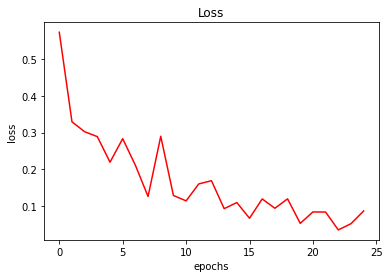

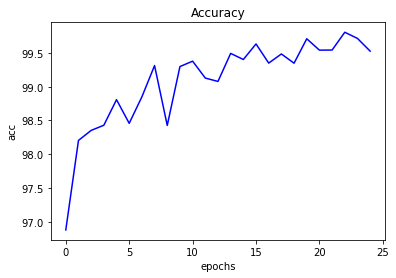

In [ ]:
red = FFNN(784, [512, 1024, 128], [relu, relu, relu], [None,None,None], 10, l_keep_prob=[1.0, 0.7, 0.5]) #red = FFNN(F, [50,30], [relu,sig], C)
#optimizer = SGD(red.parameters(), lr=1e-2, beta=0) #optimizador = SGD(red.parameters(), 0.001)
#optimizer = SGD(red.parameters(), lr=1e-1, momentum=0.9)
#optimizer = RMSProp(red.parameters(), lr=1e-1, beta=0.9, epsilon=1e-8)
optimizer = Adam(red.parameters(), lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8)

with torch.no_grad():
  loss, acc = entrenar_FFNN(red, mnist_dataset, optimizer, epochs=25, batch_size=32, device='cpu')

plot_results(loss,acc)


Esto también se aprecia con Adam, pero la variación de loss es menos que RMSProp

# Parte 3 (Opcional): Batch Normalization

In [ ]:
# Tu código debiera continuar como sigue

class FFNN():
  def __init__(self, F, l_h, l_a, l_a_params, C, l_keep_prob, bn=None):
    # debes crear los parámetros necesarios para las capas de
    # batch normalizacion
    pass

  def forward(x, predict=False):
    # debes modificar esta función para considerar las capas para las que se
    # usará batch normalization
    # también debes preocuparte de guardar los datos estadísticos que se
    # usaran en tiempo de test (predict=True)
    pass

  def backward(x,y,y_pred):
    # computar acá todos los gradientes considerando las capas de
    # batch normalization
    # no olvides considerar los nuevos parámetros entrenables.
    pass